In [4]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pgmpy as pgmpy
import seaborn as sns
from itertools import combinations, product
from pgmpy.models import NaiveBayes, BayesianModel, BayesianNetwork, MarkovModel, FactorGraph, JunctionTree
from pgmpy.inference import VariableElimination
from pgmpy.estimators import TreeSearch, ParameterEstimator, BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.factors.discrete import TabularCPD
from tabulate import tabulate as tab
import random
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [5]:
df = pd.read_csv('Dataset/heart_failure_clinical_records_dataset.csv')
print("DATASET CONTAINS {} rows and {} columns".format(df.shape[0], df.shape[1]))
display(df)

DATASET CONTAINS 299 rows and 13 columns


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


IMPORT DATASET AND ANALISYS 


DATASET DESCRIPTION:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000



DATASET BAR-GRAPH


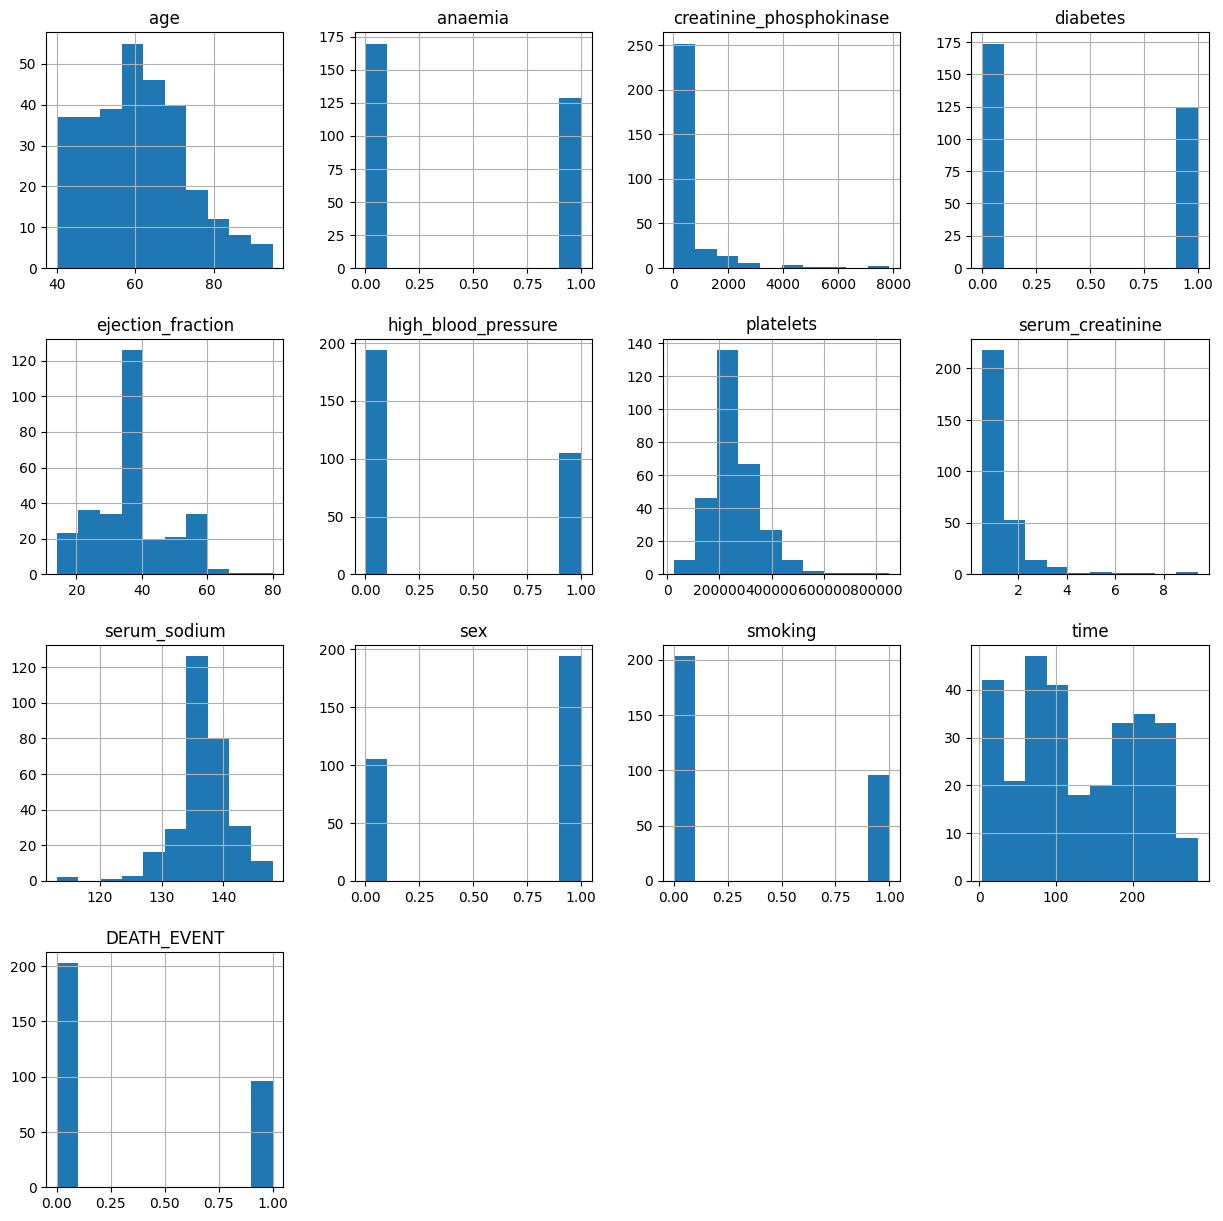

In [6]:
print("\nDATASET DESCRIPTION:")
display(df.describe())
print("\nDATASET BAR-GRAPH")
df.hist(figsize = [15,15])
plt.show()

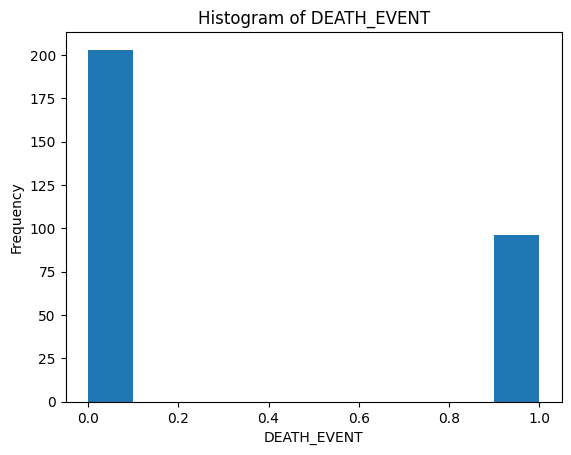

In [431]:
# Define the target variable
target = 'DEATH_EVENT'

# Plot histogram
plt.hist(df[target])
plt.title('Histogram of {}'.format(target))
plt.xlabel(target)
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Integrity Check
## sotto titolo
corpo testo 



In [432]:
display(df.columns)
np.sum(pd.isnull(df), 0)



Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

# Data cleaning and classifing into dicrete interval

In [433]:
data = {}
dic =   { 
            'age':[0,50,60,75,95], 
            'creatinine_phosphokinase':[20,200,350,550,3000,8000], 
            'ejection_fraction': [0, 40, 50, 70, 100], 
            'platelets':[0, 160000, 370000, 850000],
            'serum_creatinine': [0, 0.48, 1.0, 1.5, 3.5, 9.5],
            'serum_sodium': [110, 135, 145, 150],
            'time': [0, 70, 160, 300]
        }

#divide i valori del dataframe negli intervalli indicati dal dic per ogni nodo, assegnandoli in valore numerico tra 0 e n intervalli.  
for key, val in dic.items():
    bin = pd.cut(df[key], val)
    interval = {x: i for i, x in enumerate(bin.dtype.categories)}
    data[key] = interval
    df[key] = bin.apply(lambda x: interval[x])


for col, map in data.items():
    print(col)
    table = tab(map.items(), headers=['Interval', 'Value'], tablefmt='fancy_grid')
    print(table, end='\n\n')

df.describe()


    

age
╒════════════╤═════════╕
│ Interval   │   Value │
╞════════════╪═════════╡
│ (0, 50]    │       0 │
├────────────┼─────────┤
│ (50, 60]   │       1 │
├────────────┼─────────┤
│ (60, 75]   │       2 │
├────────────┼─────────┤
│ (75, 95]   │       3 │
╘════════════╧═════════╛

creatinine_phosphokinase
╒══════════════╤═════════╕
│ Interval     │   Value │
╞══════════════╪═════════╡
│ (20, 200]    │       0 │
├──────────────┼─────────┤
│ (200, 350]   │       1 │
├──────────────┼─────────┤
│ (350, 550]   │       2 │
├──────────────┼─────────┤
│ (550, 3000]  │       3 │
├──────────────┼─────────┤
│ (3000, 8000] │       4 │
╘══════════════╧═════════╛

ejection_fraction
╒════════════╤═════════╕
│ Interval   │   Value │
╞════════════╪═════════╡
│ (0, 40]    │       0 │
├────────────┼─────────┤
│ (40, 50]   │       1 │
├────────────┼─────────┤
│ (50, 70]   │       2 │
├────────────┼─────────┤
│ (70, 100]  │       3 │
╘════════════╧═════════╛

platelets
╒══════════════════╤═════════╕
│ Interv

,anaemia,diabetes,high_blood_pressure,sex,smoking,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.00000
mean,0.431438,0.418060,0.351171,0.648829,0.32107,0.32107
std,0.496107,0.494067,0.478136,0.478136,0.46767,0.46767
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
50%,0.000000,0.000000,0.000000,1.000000,0.00000,0.00000
75%,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000


In [26]:
#rappresenta per ogni nodo le etichette di ciascun intervallo
legenda = {
            'age':{0: 'young', 1: '50-60', 2: '60-75', 3: '75-95'},
            'creatine_phosphokinase':{0: '0-20', 1: '20-200', 2: '200-350', 3: '350-550', 4: '550-3000', 5: '3000-8000'},
            'ejection_fraction':{0: '0-40', 1: '40-50', 2: '50-70', 3: '70-100'},
            'platelets':{0: '0-160000', 1: '160000-370000', 2: '370000-850000'},
            'serum_creatinine':{0: '0-0.48', 1: '0.48-1.0', 2: '1.0-1.5', 3: '1.5-3.5', 4: '3.5-9.5'},
            'serum_sodium':{0: '110-135', 1: '135-145', 2: '145-150'},
            'time':{0: '0-70', 1: '70-160', 2: '160-300'},
            'DEATH_EVENT':{0: 'Dead', 1: 'Alive'},
            'anaemia':{0: 'No', 1: 'Yes'},
            'diabetes':{0: 'No', 1: 'Yes'},
            'high_blood_pressure':{0: 'No', 1: 'Yes'},
            'sex':{0:'Female', 1:'Male'},
            'smoking':{0: 'Yes', 1: 'No'}
        }

legenda_reverse = {key: {v: k for k, v in val.items()} for key, val in legenda.items()}
display(legenda_reverse)

{'age': {'young': 0, '50-60': 1, '60-75': 2, '75-95': 3},
 'creatine_phosphokinase': {'0-20': 0,
  '20-200': 1,
  '200-350': 2,
  '350-550': 3,
  '550-3000': 4,
  '3000-8000': 5},
 'ejection_fraction': {'0-40': 0, '40-50': 1, '50-70': 2, '70-100': 3},
 'platelets': {'0-160000': 0, '160000-370000': 1, '370000-850000': 2},
 'serum_creatinine': {'0-0.48': 0,
  '0.48-1.0': 1,
  '1.0-1.5': 2,
  '1.5-3.5': 3,
  '3.5-9.5': 4},
 'serum_sodium': {'110-135': 0, '135-145': 1, '145-150': 2},
 'time': {'0-70': 0, '70-160': 1, '160-300': 2},
 'DEATH_EVENT': {'Dead': 0, 'Alive': 1},
 'anaemia': {'No': 0, 'Yes': 1},
 'diabetes': {'No': 0, 'Yes': 1},
 'high_blood_pressure': {'No': 0, 'Yes': 1},
 'sex': {'Female': 0, 'Male': 1},
 'smoking': {'Yes': 0, 'No': 1}}

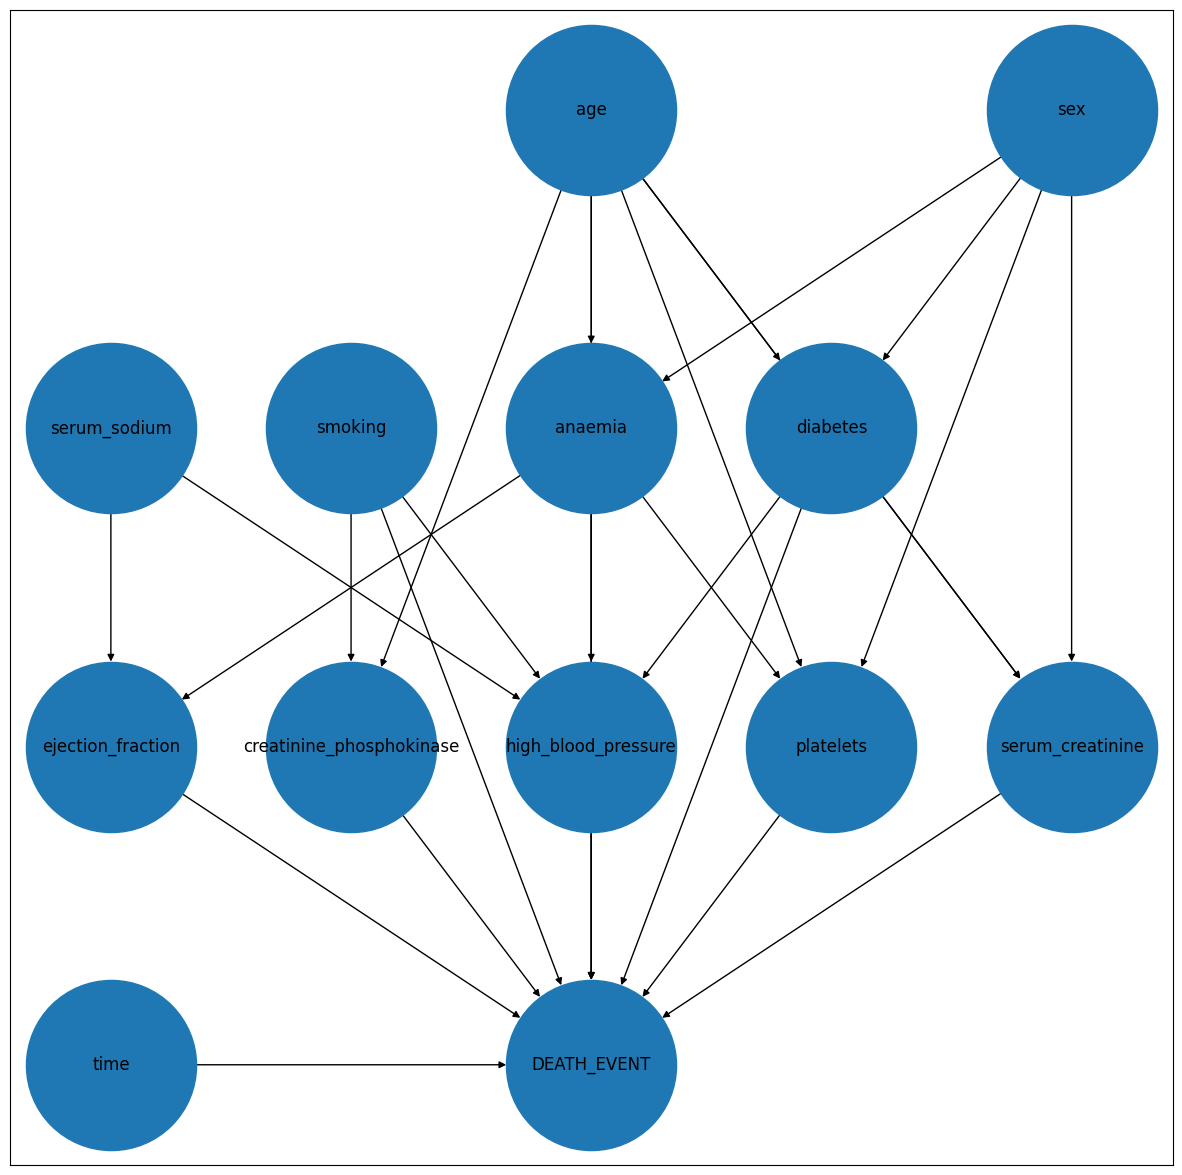

In [435]:
network = BayesianNetwork([
                    ('age','anaemia'), 
                    ('age', 'creatinine_phosphokinase'),
                    ('age', 'diabetes'),
                    ('age', 'platelets'),
                    ('age', 'serum_creatinine'),
                    ('age', 'DEATH_EVENT'),
                    ('sex','anaemia'),
                    ('sex', 'diabetes'),
                    ('sex', 'platelets'),
                    ('sex', 'serum_creatinine'),
                    ('anaemia', 'ejection_fraction'),
                    ('anaemia', 'high_blood_pressure'),
                    ('anaemia', 'platelets'),
                    ('anaemia', 'DEATH_EVENT'),
                    ('diabetes', 'high_blood_pressure'),
                    ('diabetes', 'serum_creatinine'),
                    ('diabetes', 'DEATH_EVENT'),
                    ('smoking', 'high_blood_pressure'),
                    ('smoking', 'creatinine_phosphokinase'),
                    ('smoking', 'DEATH_EVENT'),
                    ('serum_sodium', 'high_blood_pressure'),
                    ('serum_sodium', 'ejection_fraction'),
                    ('ejection_fraction', 'DEATH_EVENT'),
                    ('high_blood_pressure', 'DEATH_EVENT'),
                    ('serum_creatinine', 'DEATH_EVENT'),
                    ('creatinine_phosphokinase', 'DEATH_EVENT'),
                    ('platelets', 'DEATH_EVENT'), 
                    ('time', 'DEATH_EVENT')
                    ])

pos={
    'age':[0.75, -0.5], 'sex':[1.25, -0.5],
    'serum_sodium':[0.25, -1], 'smoking':[0.50, -1], 'anaemia':[0.75, -1], 'diabetes':[1, -1],
    'ejection_fraction':[0.25, -1.5], 'creatinine_phosphokinase':[0.50, -1.5], 'high_blood_pressure':[0.75, -1.5], 'platelets':[1, -1.5], 'serum_creatinine':[1.25, -1.5],
    'time':[0.25,-2], 'DEATH_EVENT':[0.75, -2]
    }

fig,ax = plt.subplots(1, 1, figsize=(15,15))
nx.draw_networkx(network, pos=pos, ax=ax, node_size=15000)


In [436]:
np.sum(pd.isnull(df), 0)


age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

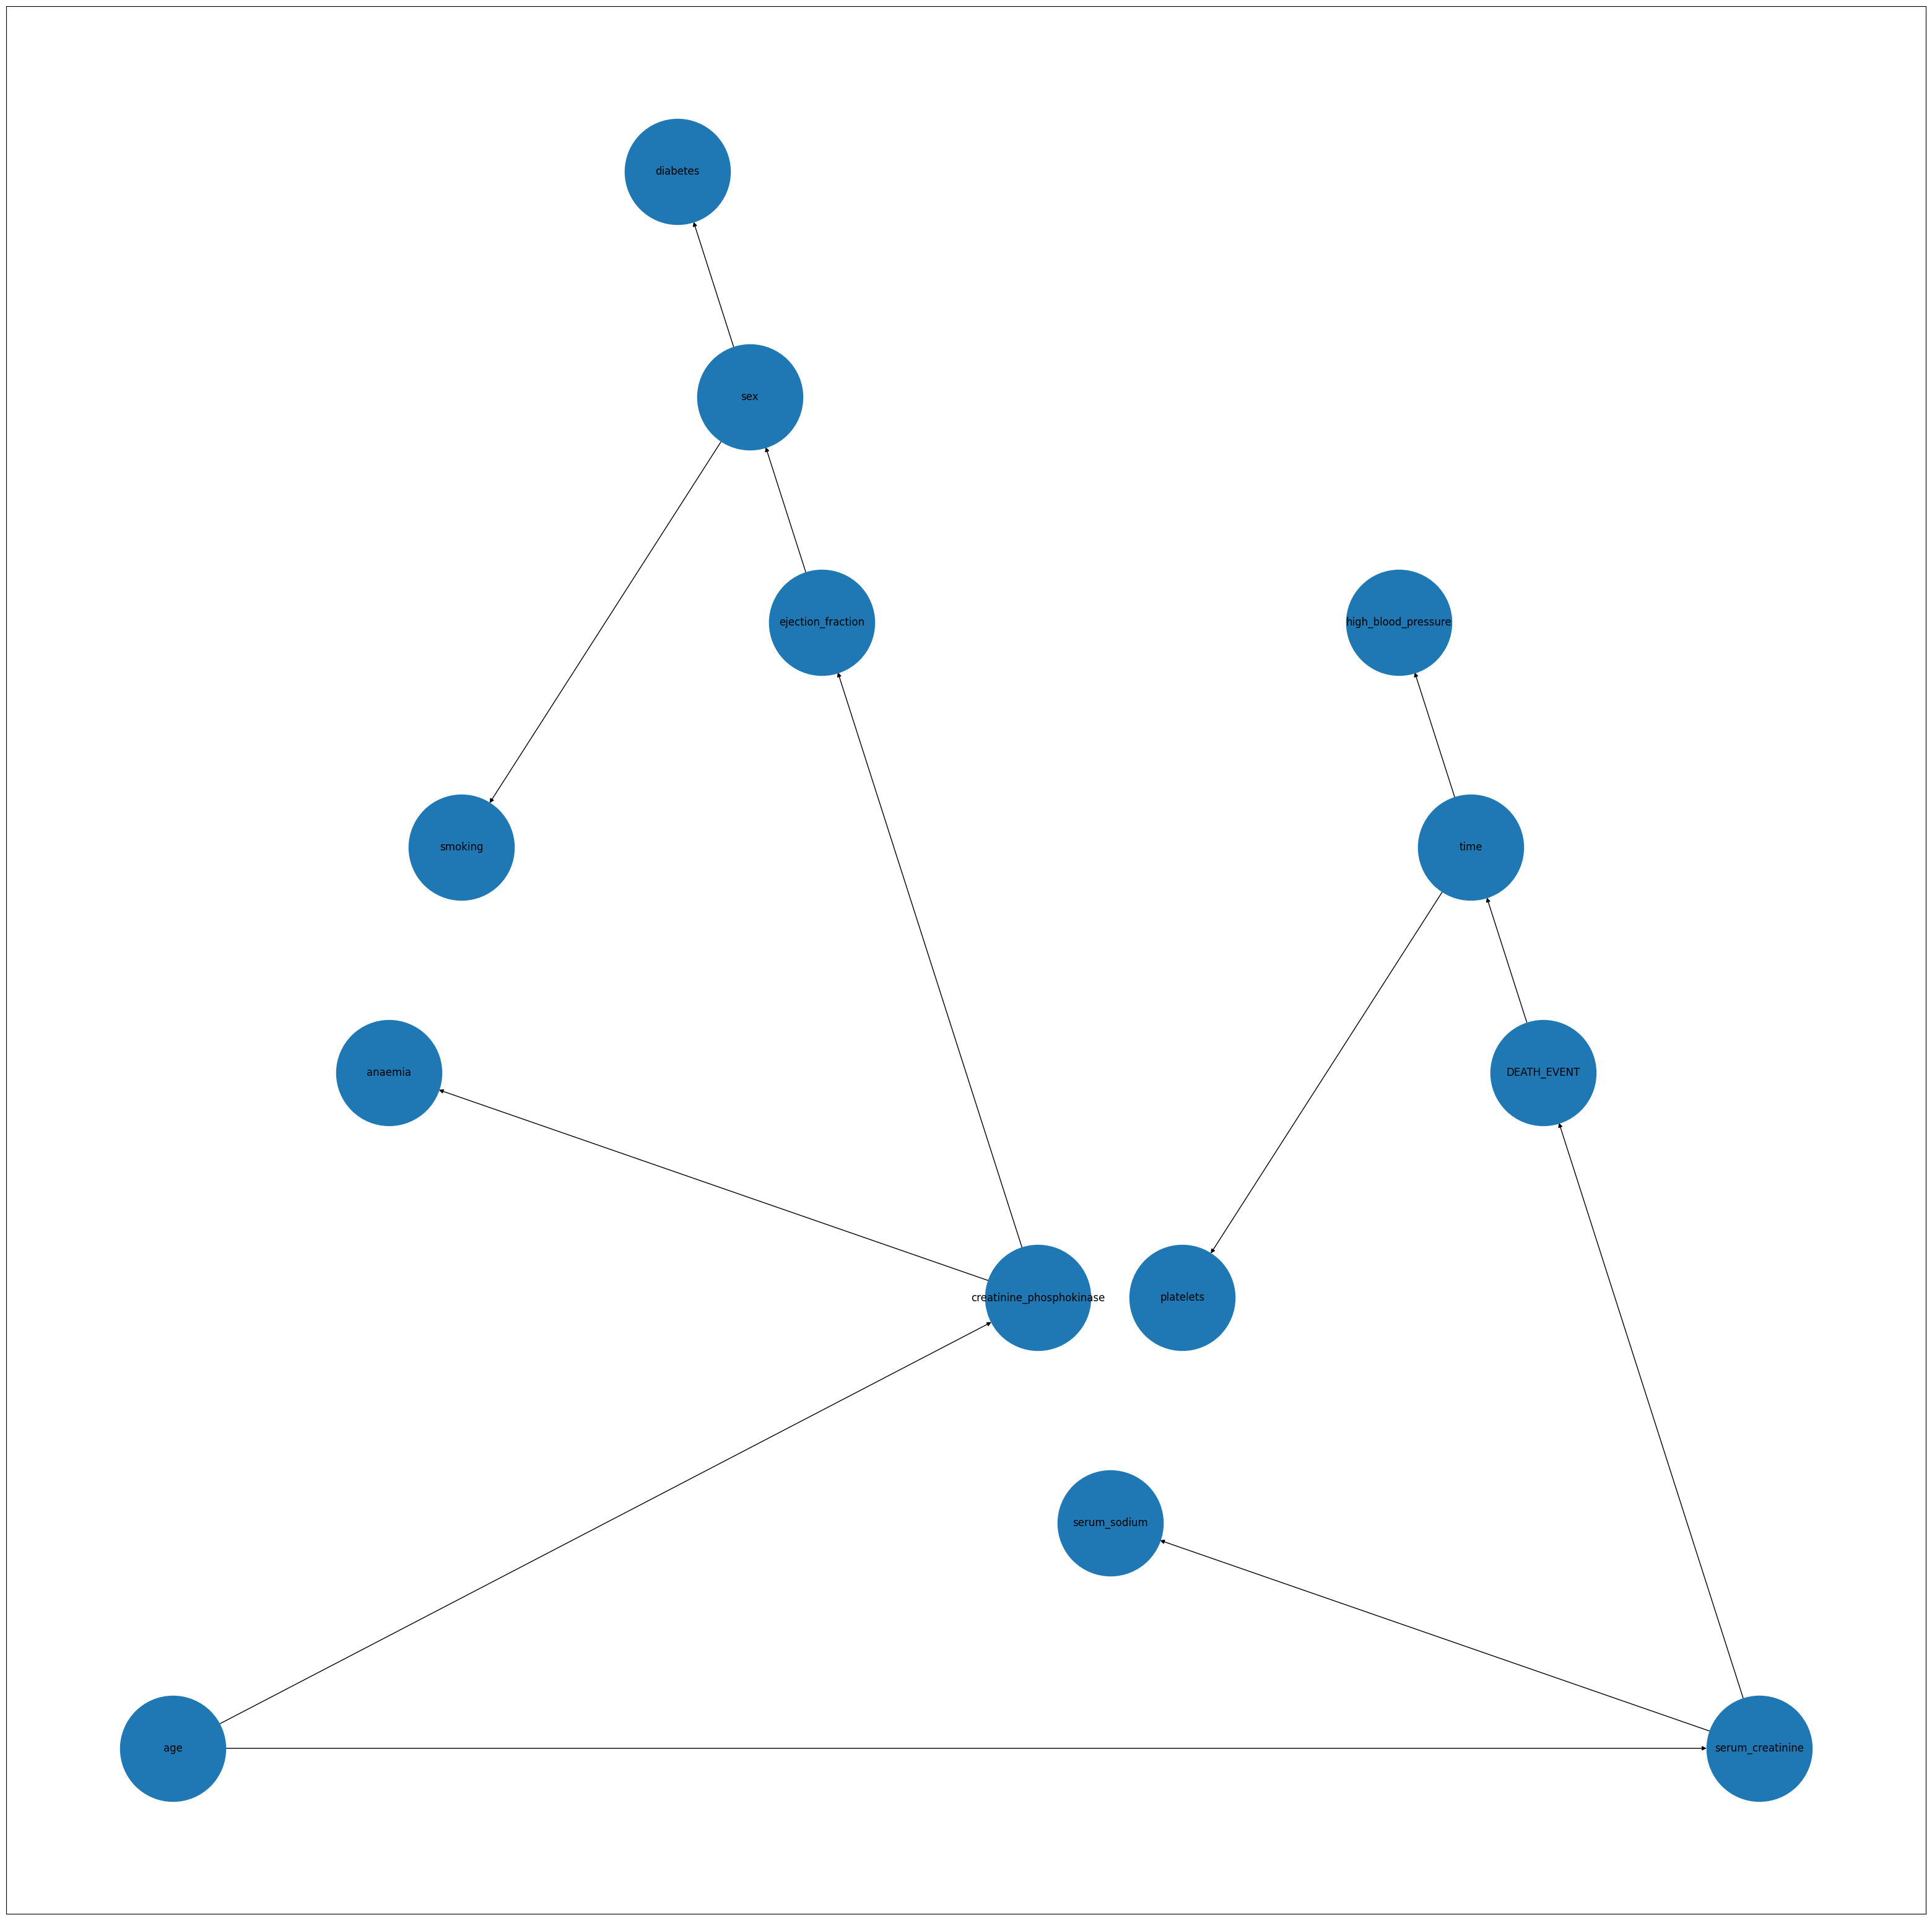

In [437]:
#tree search esemplificazione dei dati, rete bayesiana in modo stretto, si crea direttamente dai dati con una root node
ts = TreeSearch(data=df, root_node='age')
tree_model = ts.estimate(show_progress=False) 

fig,ax = plt.subplots(1, 1, figsize=(40,40))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.planar_layout(tree_model), ax=ax, node_size=15000)

In [438]:
network.fit(data=df, estimator=MaximumLikelihoodEstimator) 
#funzione di stima dai dati li mette dentro la network, stima le CPT, il codice commentato stampa le CPT, calcola le cpt dati i dati 


#mle = MaximumLikelihoodEstimator(network, data=df)
#be = BayesianEstimator(network, data=df)
#for x in df.columns:
#    print(x)
#    print("Maximum Likelihood Estimator\n", mle.estimate_cpd(x))
#   print("Bayesian Estimator\n", be.estimate_cpd(x))
print(network.get_cpds('age'))



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be chang

<TabularCPD representing P(age:4) at 0x17fe54110>

SIMPLIFY CPD? NOISY OR 

In [515]:
def tabular_values(parents_card, target_card):
    res = [[] for i in range(np.prod(target_card))]
    columns = np.prod(parents_card)    
    ma = [1 for _ in range(columns)]

    for j in range(columns):
        for i in range(target_card):
            ma[j] = ma[j] - res[i-1][j] if i > 0 else 1
            if i == target_card-1:
                res[i].append(ma[j])
            else:
                res[i].append(random.uniform(0, ma[j]))
    return res

from functools import reduce
def generate_products(lists):
    combinations = product(*lists)
    products = [reduce(lambda x, y: x * y, combination) for combination in combinations]
    return products

def noisyOr_tabular_estimator(parents: list, target : str, network=network):

    variable_card = network.get_cardinality(target)
    
    #values = [list(np.mean(network.get_cpds(node).get_values(), axis=1)) for node in parents]

    parents_card = [network.get_cardinality(node) for node in parents]
    print(parents_card)

    res = tabular_values(parents_card, variable_card)
    display(res)


    tabular = TabularCPD(target, variable_card, res, parents, parents_card)
    display(tabular)
    return tabular

# Creiamo la tabella di Noisy OR per il nodo 'diabetes'
cpd_diabetes_noisy_or = noisyOr_tabular_estimator(['diabetes', 'smoking', 'anaemia'], 'high_blood_pressure')

# Stampa la tabella di Noisy OR per il nodo 'diabetes'
print(cpd_diabetes_noisy_or)


[2, 2, 2]


[[0.9282697525479314,
  0.7320247506005255,
  0.29778246256312213,
  0.26664869012113124,
  0.6695327281926452,
  0.7318483886757619,
  0.5727547217638043,
  0.6607784765137021],
 [0.07173024745206857,
  0.2679752493994745,
  0.7022175374368779,
  0.7333513098788688,
  0.3304672718073548,
  0.26815161132423815,
  0.42724527823619574,
  0.33922152348629786]]

<TabularCPD representing P(high_blood_pressure:2 | diabetes:2, smoking:2, anaemia:2) at 0x2b5e62cf210>

+------------------------+-----+---------------------+
| diabetes               | ... | diabetes(1)         |
+------------------------+-----+---------------------+
| smoking                | ... | smoking(1)          |
+------------------------+-----+---------------------+
| anaemia                | ... | anaemia(1)          |
+------------------------+-----+---------------------+
| high_blood_pressure(0) | ... | 0.6607784765137021  |
+------------------------+-----+---------------------+
| high_blood_pressure(1) | ... | 0.33922152348629786 |
+------------------------+-----+---------------------+


In [ ]:
print("Total number of valid indipendencies: ", len(network.get_independencies().get_assertions()))
for node in network.nodes():
    print("Local independencies: ", network.local_independencies(node))

Total number of valid indipendencies:  20080
Local independencies:  (age ⟂ sex, time, smoking, serum_sodium)
Local independencies:  (anaemia ⟂ smoking, diabetes, serum_creatinine, creatinine_phosphokinase, serum_sodium, time | age, sex)
Local independencies:  (creatinine_phosphokinase ⟂ diabetes, ejection_fraction, anaemia, high_blood_pressure, sex, serum_creatinine, platelets, serum_sodium, time | age, smoking)
Local independencies:  (diabetes ⟂ smoking, ejection_fraction, creatinine_phosphokinase, anaemia, platelets, serum_sodium, time | age, sex)
Local independencies:  (platelets ⟂ smoking, diabetes, ejection_fraction, high_blood_pressure, serum_creatinine, creatinine_phosphokinase, serum_sodium, time | age, sex, anaemia)
Local independencies:  (serum_creatinine ⟂ smoking, ejection_fraction, anaemia, high_blood_pressure, creatinine_phosphokinase, platelets, serum_sodium, time | age, sex, diabetes)
Local independencies:  (DEATH_EVENT ⟂ sex, serum_sodium | age, diabetes, smoking, ejec

Performing inference

Question: Probability of Anaemia and Diabetes affects the probability of High Blood Pressure?

The function below is used to combine all possible values of the variables into a single dataframe

In [ ]:
def cartesian_product(evidences):

    # Remove Given Evidence
    given = {key: value for key, value in evidences.items() if value is not None}
    combine = {key: value for key, value in evidences.items() if value is None}

    # Get values for each specified key
    values = [list(legenda_reverse[key]) for key in combine]
    # Calculate all combinations of values across specified keys
    combinations = list(product(*values))

    # Pairing keys with values
    combinations = [{key: value for key, value in zip(combine.keys(), combination)} for combination in combinations ]
    for combination in combinations:
        combination.update(given)

    # append given evidence to each combination
    return combinations

The function below is used to calculate the probability of a given query variable value given an evidence variable value. The function takes as input the query variable, the evidence variable, the evidence variable value, the Bayesian network. The function returns the probability of the query variable value given the evidence variable value.

In [ ]:
def inference(evidences : dict, target : str, network=network, combinations=None):
    inferences = VariableElimination(network)
    res = {}
    
    if combinations is None:
        combinations = cartesian_product(evidences)
   
    for comb in combinations:
        evidence = {key: legenda_reverse[key][value] for key, value in comb.items()}

        q = inferences.query(variables=[target], evidence=evidence)
        res[','.join(comb.values())] = q.values
        
    return res

The function below is used to grph the probabilities of the variables using a bar plot

In [ ]:
def plot_bar(data, title, evidences, target, fig_size=(50, 5)):
    dataFrame = pd.DataFrame([[str(x), legenda[target][bars], float(y)]
                 for x in data.keys()
                 for bars, y in enumerate(data[x])],
                 columns=[str(evidences), str(target), 'Probability'])

    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    sns.barplot(x=str(evidences), y='Probability', hue=str(target), data=dataFrame, ax=ax, palette='dark')
    plt.title(title)
    plt.show()

Inferring the probability of serus creatinine given the probability of age, sex and serum sodium

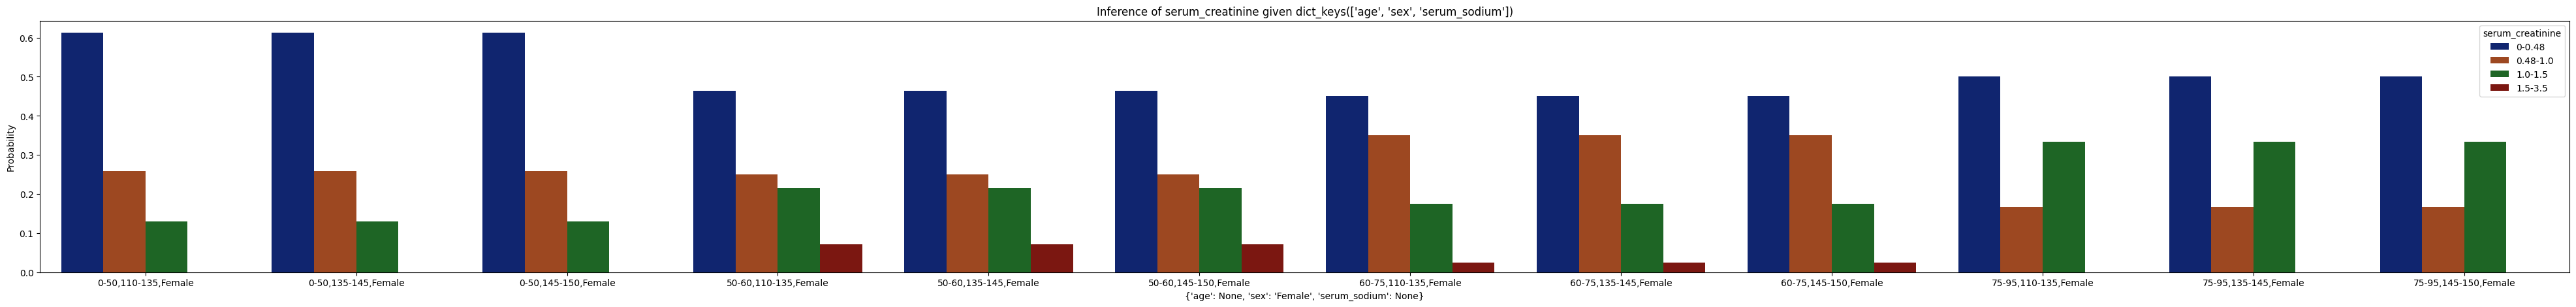

In [ ]:
evidences = {'age':None,'sex':'Female', 'serum_sodium':None}
title = "Inference of serum_creatinine given {}".format(evidences.keys())

inf  = inference(evidences, 'serum_creatinine', network)
plot_bar(inf, title, evidences, 'serum_creatinine')

Inferring the probability of Heart failure of a 74 year old that smoke

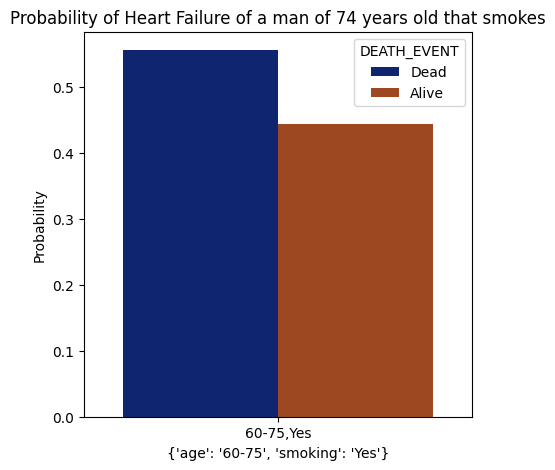

In [ ]:
title='Probability of Heart Failure of a man of 74 years old that smokes'
evidence = {'age':'60-75', 'smoking':'Yes'}
target = 'DEATH_EVENT'

inf = inference(evidence, target, network)
plot_bar(inf, title, evidence, target, fig_size=(5, 5))




Markonv Blanket

In [ ]:
#markov_blanket = set(inference.markov_blanket('serum_creatinine'))
print('Checking Markov blankets')
for node in network.nodes():
    print(f'The Markov blanket of node {node} is {network.get_markov_blanket(node)}')
print()

Checking Markov blankets
The Markov blanket of node age is ['diabetes', 'DEATH_EVENT', 'smoking', 'ejection_fraction', 'anaemia', 'high_blood_pressure', 'sex', 'serum_creatinine', 'creatinine_phosphokinase', 'platelets', 'time']
The Markov blanket of node anaemia is ['age', 'DEATH_EVENT', 'diabetes', 'ejection_fraction', 'smoking', 'high_blood_pressure', 'sex', 'serum_creatinine', 'creatinine_phosphokinase', 'platelets', 'serum_sodium', 'time']
The Markov blanket of node creatinine_phosphokinase is ['age', 'diabetes', 'DEATH_EVENT', 'smoking', 'ejection_fraction', 'anaemia', 'high_blood_pressure', 'serum_creatinine', 'platelets', 'time']
The Markov blanket of node diabetes is ['age', 'DEATH_EVENT', 'smoking', 'ejection_fraction', 'anaemia', 'high_blood_pressure', 'sex', 'serum_creatinine', 'creatinine_phosphokinase', 'platelets', 'serum_sodium', 'time']
The Markov blanket of node platelets is ['age', 'DEATH_EVENT', 'diabetes', 'smoking', 'ejection_fraction', 'anaemia', 'high_blood_pres

In [ ]:
markov_blanket = set(network.get_markov_blanket('serum_sodium'))
print(f"Feature rilevanti per il nodo '{'serum_sodium'}': {markov_blanket}")

Feature rilevanti per il nodo 'serum_sodium': {'diabetes', 'smoking', 'ejection_fraction', 'anaemia', 'high_blood_pressure'}


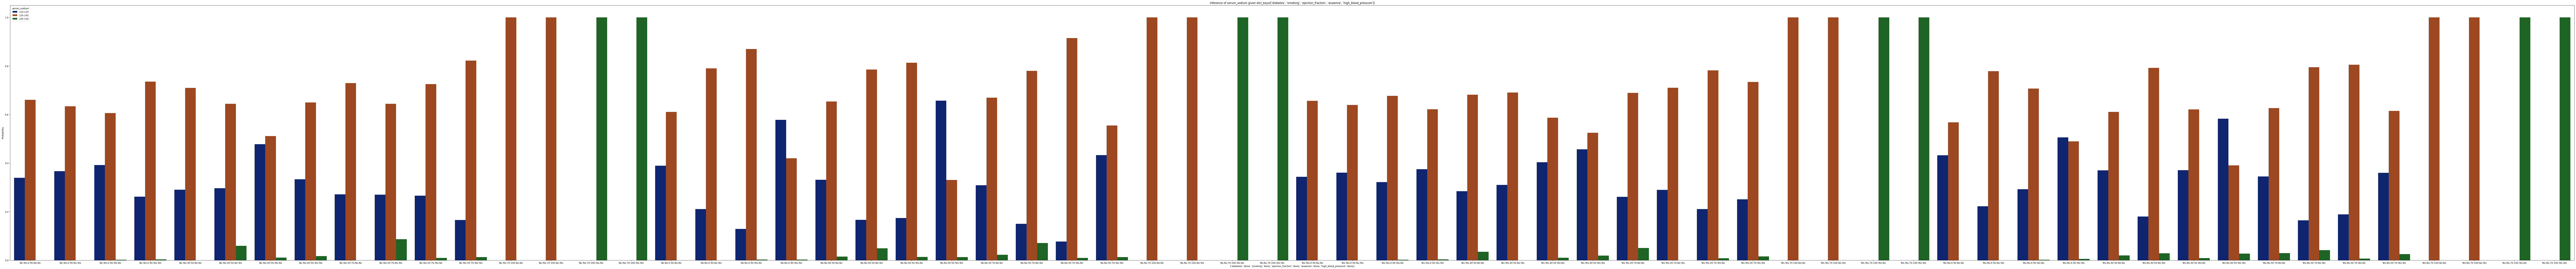

In [ ]:
evidences = {key: None for key in markov_blanket}

inf = inference(evidences, 'serum_sodium', network)
plot_bar(inf, 'Inference of serum_sodium given {}'.format(evidences.keys()), evidences, 'serum_sodium', fig_size=(200, 20))